In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

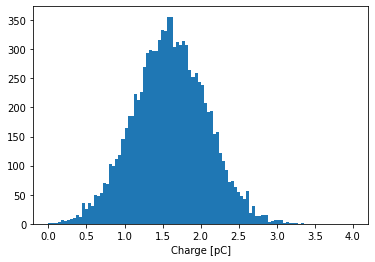

In [2]:
# generate fake data
s = np.random.normal(loc=1.6, scale=1.6*0.3, size=10000)
ydata, xbin, p = plt.hist(s, bins=100, range=(0,4));
plt.xlabel('Charge [pC]')
xdata = (xbin[1:]+xbin[:-1])*0.5

In [3]:
# define Gaussian
def gaus(x, A, mu, sigma):
  arg = (x-mu)/sigma
  return A*np.exp(-0.5*arg*arg)

In [4]:
# do chi2 fit in a range. We avoid low statistics bin for chi2 fit. This is generally true as chi2 fit does not do well when statistics is low. 
xmin = 0.5
xmax = 2.5
mask = (xdata>xmin) & (xdata<xmax)
xdata = xdata[mask]
ydata = ydata[mask]
sigma = np.sqrt(ydata)

popt, pcov = curve_fit(gaus, xdata, ydata, sigma=sigma)
print('Best fit parameters:', popt)
print('Covariance Matrix:\n', pcov)

Best fit parameters: [332.83692646   1.59408137   0.47514448]
Covariance Matrix:
 [[ 1.40294142e+01 -1.16681999e-03 -1.05311010e-02]
 [-1.16681999e-03  2.18256807e-05  3.23753135e-06]
 [-1.05311010e-02  3.23753135e-06  1.91929514e-05]]


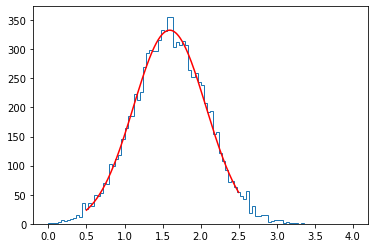

In [7]:
plt.hist(s, bins=100, range=(0,4), histtype='step');

x = np.linspace(xmin, xmax, 400)
y = gaus(x, popt[0], popt[1], popt[2])
plt.plot(x, y, color='r');

In [11]:
def calc_chi2(func, popt, xdata, ydata, sigma):
  ymodel = func(xdata, popt[0], popt[1], popt[2])
  res = ydata-ymodel 
  chi2 = np.square(res/sigma)
  return np.sum(chi2)

def calc_reduced_chi2(func, popt, xdata, ydata, sigma):
  npar = len(popt) # num of free parameters
  dof = len(xdata) - npar
  return calc_chi2(func, popt, xdata, ydata, sigma)/dof


print('Your chi2 is:', calc_chi2(gaus, popt, xdata, ydata, sigma))
print('Your reduced chi2 is:', calc_reduced_chi2(gaus, popt, xdata, ydata, sigma))

Your chi2 is: 32.426572839582
Your reduced chi2 is: 0.7049254965126522


In [12]:
# compute standard error from the fit
err = np.diag(pcov)
err = np.sqrt(err)
print("A: %.3e +/- %.3e" % (popt[0], err[0]))
print("mu: %.3e +/- %.3e" % (popt[1], err[1]))
print("sigma: %.3e +/- %.3e" % (popt[2], err[2]))

A: 3.328e+02 +/- 3.746e+00
mu: 1.594e+00 +/- 4.672e-03
sigma: 4.751e-01 +/- 4.381e-03
